In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Chosen Hyper Params
chosen_pca_components = 15
chosen_svm_cost = 10
chosen_svm_kernel = "rbf"
chosen_scaler_q = 5

In [3]:
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.25, random_state=999)

(samples, features, frames) = X_train.shape


In [4]:


# scaler = RobustScaler(quantile_range=(scaler_q_min, scaler_q_max))
# X_transposed = X_train.transpose(0,2,1)
# arr = np.reshape(X_transposed, (samples * frames, features))
# scaled = scaler.fit_transform(arr)

# pca = PCA(n_components=pca_components)
# reduced_X = pca.fit(scaled)

In [5]:
# flat_X = np.empty((samples, frames, pca_components))

# for i in range(samples):
#     flat_X[i] = pca.transform(scaler.transform(X_transposed[i]))

# flat_X = np.reshape(flat_X, (samples, frames * pca_components))
# print(flat_X.shape)

In [6]:
# clf = svm.SVC(cache_size=1000, verbose=True, class_weight='balanced', C = svm_cost, kernel=svm_kernel)
# clf.fit(flat_X, y_train)

In [7]:
# (samples, features, frames) = X_test.shape

# X_test_transposed = X_test.transpose(0,2,1)
# arr = np.reshape(X_test_transposed, (samples * frames, features))
# scaled = scaler.transform(arr)

# reduced_X_test = pca.transform(scaled)

# flat_X_test = np.empty((samples, frames, pca_components))

# for i in range(samples):
#     flat_X_test[i] = pca.transform(scaler.transform(X_test_transposed[i]))

# flat_X_test = np.reshape(flat_X_test, (samples, frames * pca_components))
# print(flat_X_test.shape)

# y_pred = clf.predict(flat_X_test)

In [8]:
# print(y_test[0:10])
# print(y_pred[0:10])
# print(np.array(list(classes.REVERSE_CLASSES.keys())))

# cm = confusion_matrix(y_test, y_pred, labels=np.array(list(classes.REVERSE_CLASSES.keys())))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.CLASSES)
# disp.plot()

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from skopt import BayesSearchCV
import json


class SVMClassifier(BaseEstimator):
     def __init__(self, pca_components = chosen_pca_components, svm_cost = chosen_svm_cost, svm_kernel = chosen_svm_kernel, scaler_q = chosen_scaler_q):
          self.pca_components = pca_components 
          self.svm_cost = svm_cost 
          self.svm_kernel = svm_kernel
          self.scaler_q = scaler_q

          self.clf = None
          self.scaler = None
          self.pca = None

     def fit(self, X, y):

          (samples, features, frames) = X.shape

          scaler_q_min = self.scaler_q 
          scaler_q_max = 100 - self.scaler_q

          self.scaler = RobustScaler(quantile_range=(scaler_q_min, scaler_q_max))
          X_transposed = X.transpose(0,2,1)
          arr = np.reshape(X_transposed, (samples * frames, features))
          scaled = self.scaler.fit_transform(arr)

          self.pca = PCA(n_components=self.pca_components)
          reduced_X = self.pca.fit(scaled)

          flat_X = np.empty((samples, frames, self.pca_components))

          for i in range(samples):
               flat_X[i] = self.pca.transform(self.scaler.transform(X_transposed[i]))

          flat_X = np.reshape(flat_X, (samples, frames * self.pca_components))

          self.clf = svm.SVC(cache_size=1000, verbose=True, class_weight='balanced', C = self.svm_cost, kernel=self.svm_kernel)
          self.clf.fit(flat_X, y)

          self.is_fitted_ = True
          return self

     def predict(self, X):

          if not self.is_fitted_:
               raise Exception("Not fitted")

          (samples, features, frames) = X.shape

          X_test_transposed = X.transpose(0,2,1)
          arr = np.reshape(X_test_transposed, (samples * frames, features))
          scaled = self.scaler.transform(arr)


          flat_X_test = np.empty((samples, frames, self.pca_components))

          for i in range(samples):
               flat_X_test[i] = self.pca.transform(self.scaler.transform(X_test_transposed[i]))

          flat_X_test = np.reshape(flat_X_test, (samples, frames * self.pca_components))

          y_pred = self.clf.predict(flat_X_test)

          return y_pred

In [10]:
# clf = SVMClassifier()
# clf.fit(X,y)
# y_pred = clf.predict(X_test)

In [11]:
parameters = {
    'svm_cost': [0.5, 1, 5, 10], 
    "pca_components": [7, 10, 15],
    "svm_kernel": ["poly", "rbf"],
    "scaler_q": [25, 15, 5]
}

In [12]:
OPTIMIZE = False

if OPTIMIZE:
    estimator = SVMClassifier()
    bayes = BayesSearchCV(estimator, parameters, n_iter=20, n_jobs=1,scoring="f1_weighted", verbose=True, cv=ShuffleSplit(n_splits=1, test_size=0.2))
    bayes.fit(X_train, y_train)

    clf = SVMClassifier(**bayes.best_params_)
    clf.fit(X_train, y_train)
else:
    clf = SVMClassifier()
    clf.fit(X_train, y_train)


[LibSVM]...*..*
optimization finished, #iter = 5983
obj = -873.262950, rho = -0.509202
nSV = 2031, nBSV = 282
.....*...*
optimization finished, #iter = 8555
obj = -2147.925410, rho = -1.289051
nSV = 2660, nBSV = 1039
....*..*
optimization finished, #iter = 6823
obj = -1343.047387, rho = -1.544619
nSV = 2113, nBSV = 619
......*....*
optimization finished, #iter = 10225
obj = -3798.896648, rho = -1.816244
nSV = 3431, nBSV = 1797
....*...*
optimization finished, #iter = 7536
obj = -1326.954011, rho = -1.172280
nSV = 2286, nBSV = 568
.....*...*
optimization finished, #iter = 8137
obj = -1198.534509, rho = -0.996638
nSV = 2486, nBSV = 428
.....*..*
optimization finished, #iter = 7954
obj = -3135.331046, rho = -2.679536
nSV = 2746, nBSV = 1606
....*...*
optimization finished, #iter = 7196
obj = -2516.589790, rho = -1.014158
nSV = 2467, nBSV = 1241
....*...*
optimization finished, #iter = 7324
obj = -2464.820228, rho = -2.335856
nSV = 2409, nBSV = 1292
.....*....*
optimization finished, #iter

In [13]:
y_pred = clf.predict(X_test)
f1 = str(f1_score(y_test, y_pred, average='micro'))
accuracy = str(accuracy_score(y_test, y_pred))


print(f1, accuracy, clf.get_params())

with open('svm_params.txt', 'w') as file:
     file.write(accuracy)
     file.write("\n")
     file.write(f1)
     file.write("\n")
     file.write(json.dumps(clf.get_params()))

0.9306843267108168 0.9306843267108168 {'pca_components': 15, 'scaler_q': 5, 'svm_cost': 10, 'svm_kernel': 'rbf'}


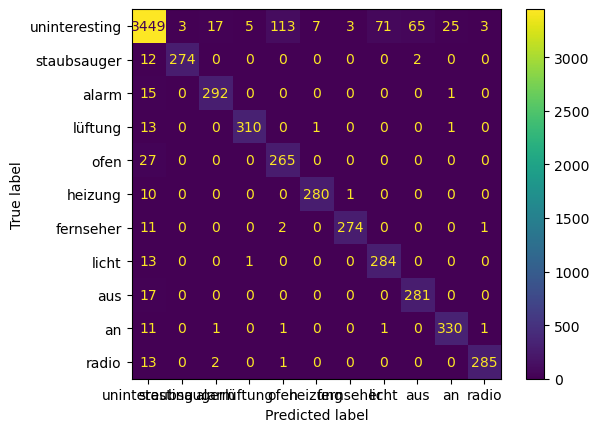

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=np.array(list(classes.REVERSE_CLASSES.keys())))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.CLASSES)
disp.plot()